# Constants

In [1]:
WORK_DIR_PATH = ".."
MODEL_NAME = "RLNet_BPR_AMusic"

# Split
FILTER_BY = "user"
TRN_VAL_TST_RATIO = [0.8, 0.1, 0.1]
TRN_NEG_PER_POS_RATIO = 1
TST_NEG_PER_POS_RATIO = 100
NEG_PER_POS_RATIO = [TRN_NEG_PER_POS_RATIO, TRN_NEG_PER_POS_RATIO, TST_NEG_PER_POS_RATIO, TST_NEG_PER_POS_RATIO]
TRN_BATCH_SIZE = 128
TST_BATCH_SIZE = 5
BATCH_SIZE = [TRN_BATCH_SIZE, TRN_BATCH_SIZE, TST_BATCH_SIZE, TST_BATCH_SIZE]

# Model
N_FACTORS = 32
HIDDEN_RL = [N_FACTORS*4, N_FACTORS*2, N_FACTORS, N_FACTORS // 2]
HIDDEN_ML = [N_FACTORS*2, N_FACTORS*2, N_FACTORS, N_FACTORS // 2]
DROPOUT = 0.2

# How to Learn
TASK_TYPE = 'bpr'
LEARNING_RATE = 1e-4
LAMBDA_ = 1e-2

# Fit
N_EPOCHS = 1000
METRIC = 'ndcg'
INTERVAL = 10
PATIENCE = 10
DELTA = 1e-3

# Config

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.chdir(WORK_DIR_PATH)
print(f"DIRECTORY: {os.getcwd()}")

DIRECTORY: c:\Users\jayar\Desktop\바탕 화면\탱구의대학원탈출기\RS-DeepCF


In [3]:
import json
import pandas as pd
import torch

In [4]:
from DeepCF import deepcf, loop
from MYUTILS import (
    ranking,
    utils,
)
from MYUTILS.config.constants import (
    DEFAULT_USER_COL,
    DEFAULT_ITEM_COL,
    DEFAULT_RATING_COL,
    DEFAULT_LABEL_COL,
    DEFAULT_TIMESTAMP_COL,
    DEFAULT_PREDICTION_COL,
    DEFAULT_K,
    SEED,
)

In [5]:
# Seed
utils.seed.reset(SEED)

SETTING ALL SEEDS TO 42...
ALL SEEDS SET


In [6]:
# Available GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Data Preparation

In [7]:
# JSON lines 형식의 파일 열기
with open('./data/amusic.json', 'r', encoding='utf-8') as f:
    records = [json.loads(line) for line in f]

# reviewerID와 asin만 추출
filtered_records = [{'reviewerID': r['reviewerID'], 'asin': r['asin']} for r in records]

# DataFrame으로 변환
data = pd.DataFrame(filtered_records)

In [8]:
# Columns
kwargs = dict(
    col_user='reviewerID', 
    col_item='asin', 
)

data = utils.data.rename_columns(data, **kwargs)


# Label encoding
kwargs = dict(
    data=data, 
    col_user=DEFAULT_USER_COL, 
    col_item=DEFAULT_ITEM_COL,
)

data, user_label, item_label = utils.data.label_encoding(**kwargs)


# Number of user, item
N_USERS = data[DEFAULT_USER_COL].nunique()
N_ITEMS = data[DEFAULT_ITEM_COL].nunique()

In [9]:
# data Description
utils.data.description(data)

number of user: 5541
number of item: 3568
total interaction: 64706
interaction density: 0.3273 %
max interaction of user: 578
top 10.0 % interaction of user: 20.0
mean interaction of user: 11
mean interaction of item: 18


In [10]:
kwargs = dict(
    data=data,
    n_users=N_USERS,
    n_items=N_ITEMS,
    col_user=DEFAULT_USER_COL,
    col_item=DEFAULT_ITEM_COL,
)

dataloader = ranking.trn_val_tst.Module(**kwargs)

kwargs = dict(
    filter_by=FILTER_BY,
    trn_val_tst_ratio=TRN_VAL_TST_RATIO,
    neg_per_pos=NEG_PER_POS_RATIO,
    batch_size=BATCH_SIZE,
    seed=SEED,
    )

loaders, histories, interactions = dataloader.get(**kwargs)
trn_loader, val_loader, tst_loader, loo_loader = loaders

# Modeling

In [ ]:
kwargs = dict(
    n_users=N_USERS,
    n_items=N_ITEMS,
    hidden=HIDDEN_RL,
    dropout=DROPOUT,
    interactions=interactions,
)

model = deepcf.rlnet.Module(**kwargs)

In [12]:
kwargs = dict(
    model=model,
    trn_neg_per_pos_ratio=TRN_NEG_PER_POS_RATIO,
    task_type=TASK_TYPE,
    lr=LEARNING_RATE,
    lambda_=LAMBDA_,
)

trainer = loop.trainer.Module(**kwargs)

# Train

In [13]:
kwargs = dict(
    trn_loader=trn_loader,
    val_loader=val_loader,
    loo_loader=loo_loader,
    n_epochs=N_EPOCHS,
    metric=METRIC,
    interval=INTERVAL,
    patience=PATIENCE,
    delta=DELTA,
)

history = trainer.fit(**kwargs)

LEAVE ONE OUT BEST EPOCH: 21
LEAVE ONE OUT BEST SCORE: 0.2859


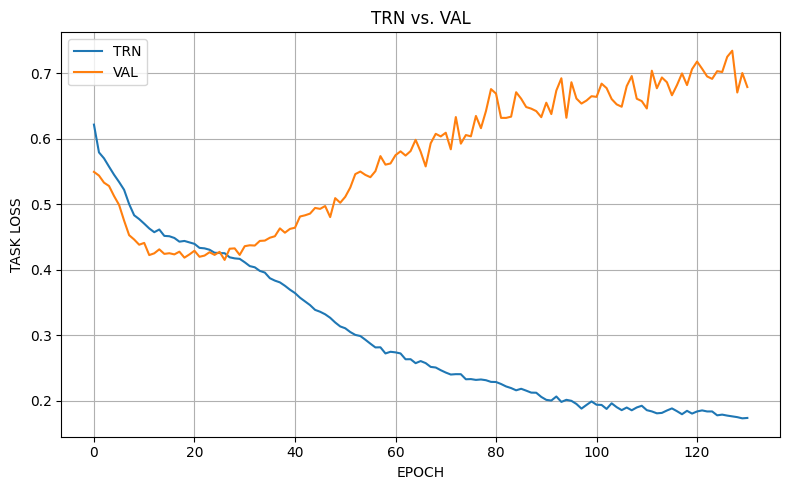

In [14]:
utils.visualizer.plot_loss(history, 'TASK LOSS')

# Test

In [15]:
TRUE_COL_LIST = [DEFAULT_USER_COL, DEFAULT_ITEM_COL, DEFAULT_LABEL_COL]
PRED_COL_LIST = [DEFAULT_USER_COL, DEFAULT_ITEM_COL, DEFAULT_PREDICTION_COL]

In [16]:
kwargs = dict(
    model=model,
    tst_loader=tst_loader,
)

result = loop.predictor.predict(**kwargs)

TST: 100%|██████████| 1224/1224 [00:03<00:00, 311.25it/s]


In [17]:
top_k_list = [5, 10, 15, 20, 50, 100]
eval_list = []

for TOP_K in top_k_list:
    kwargs = dict(
        rating_true=result[TRUE_COL_LIST],
        rating_pred=result[PRED_COL_LIST],
        k=TOP_K,
    )
    eval = ranking.metrics.eval_top_k(**kwargs)
    eval_list.append(eval)

eval_df = pd.DataFrame(eval_list)
eval_df

,top_k,hit_ratio,precision,recall,map,ndcg
0,5,0.363003,0.075286,0.318183,0.188818,0.227835
1,10,0.504227,0.054376,0.449414,0.207508,0.271706
2,15,0.602437,0.044588,0.542146,0.215556,0.297619
3,20,0.672800,0.038352,0.612961,0.220101,0.315449
4,50,0.881154,0.021551,0.830137,0.228623,0.361938
5,100,0.996022,0.012974,0.963946,0.230993,0.385842


# Save

In [18]:
PATH = f'./checkpoints/{MODEL_NAME}.pth'

kwargs = dict(
    model=model, 
    path=PATH,
)

utils.checkpoint.save(**kwargs)